# Comparing perfomances of regression models

### Load datasets

In [50]:
import pandas as pd

def load_dat_file(filepath):
    return pd.read_csv(filepath, sep=r'\s+', header=None, engine='python')

# === LOAD DATASETS ===

d1 = load_dat_file("../ArtificialData/DS-5-1-GAP-0-1-N-0_v2.dat")   # Ground truth
d2 = load_dat_file("../ArtificialData/DS-5-1-GAP-1-1-N-1_v2.dat")   # Noise level 1
d3 = load_dat_file("../ArtificialData/DS-5-1-GAP-5-1-N-3_v2.dat")   # Noise level 2

x_truth = d1.iloc[:, 0].values
y_truth = d1.iloc[:, 1].values

x_noise1 = d2.iloc[:, 0].values
y_noise1 = d2.iloc[:, 1:101].values

x_noise2 = d3.iloc[:, 0].values
y_noise2 = d3.iloc[:, 1:101].values

## Implementation of regression methods

In [51]:
from methods.linear_regression import fit_linear_models
from methods.polynomial_regression import fit_polynomial_models
from methods.fourier_regression import fit_fourier_models
from methods.splines_regression import fit_spline_models
from methods.kernel_regression import fit_kernel_ridge_models
from methods.grnn_regression import fit_grnn_models
from utils import load_predictions, load_metrics

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

In [53]:
# Run regression models
def run_regression_models(x_train, y_train, x_test, y_test):
    fit_linear_models(x_train, y_train, x_test, y_test)
    fit_polynomial_models(x_train, y_train, x_test, y_test)
    fit_fourier_models(x_train, y_train, x_test, y_test)
    fit_spline_models(x_train, y_train, x_test, y_test)
    fit_kernel_ridge_models(x_train, y_train, x_test, y_test)
    fit_grnn_models(x_train, y_train, x_test, y_test)

In [54]:
# Read json files and convert them to a DataFrame
def read_json_files(model_names):
    all_metrics = [load_metrics(name) for name in model_names]
    return pd.DataFrame(all_metrics)

#### Create a DataFrame for each dataset analysis

In [55]:
model_names = ["fourier", "grnn", "kernel", "linear", "polynomial", "splines"]

In [56]:
# Store metrics and predictions for each dataset with noise
df_results = []
predic = []

# Noise level 1
run_regression_models(x_noise1, y_noise1, x_truth, y_truth)
df_results.append(read_json_files(model_names))
# Get predictions for each model
pd1 = {name: load_predictions(name) for name in model_names}
predic.append(pd1)

In [57]:
# Noise level 2
run_regression_models(x_noise2, y_noise2, x_truth, y_truth)
df_results.append(read_json_files(model_names))
# Get predictions for each model
pd2 = {name: load_predictions(name) for name in model_names}
predic.append(pd2)

#### Plot the predictions

In [79]:
def plot_predictions_for_each_model(x_test, y_truth, models_preds_dict, dataset):
    num_models = len(models_preds_dict)
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))  # 2x3 subplots
    axes = axes.flatten()  # Flatten to easily index with one loop

    title_prefix="Model"

    for i, (model_name, Y_preds) in enumerate(models_preds_dict.items()):
        ax = axes[i]

        # Plot all but the last realization
        for j in range(Y_preds.shape[1] - 1):
            ax.plot(x_test, Y_preds[:, j], color='cornflowerblue', alpha=0.6, linewidth=1)

        # Plot the last realization with label
        ax.plot(x_test, Y_preds[:, -1], color='cornflowerblue', alpha=0.8, linewidth=1, label='Realizations')

        # Plot the mean of predictions
        mean_pred = np.mean(Y_preds, axis=1)
        ax.plot(x_test, mean_pred, 'r-', linewidth=2.5, label='Mean Prediction')

        # Plot ground truth
        ax.plot(x_test, y_truth, 'k--', linewidth=2, label='Ground Truth')

        ax.set_title(f"{title_prefix}: {model_name}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend()

    # If fewer than 6 models, hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"Dataset: {dataset}", fontsize=16, y=0.92)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

#### Plot Bias-Variance Tradeoff

In [59]:
def plot_comparison_bias_vs_variance(bias_values, variance_values, model_names):
    scenarios = ["DS-5-1-GAP-1-1-N-1_v2", "DS-5-1-GAP-5-1-N-3_v2"]
    colors = ['blue', 'green']

    plt.figure(figsize=(10, 6))

    for i in range(2):
        plt.scatter(
            bias_values[i],
            variance_values[i],
            label=scenarios[i],
            color=colors[i],
            s=100,
            alpha=0.7
        )

        for j, model in enumerate(model_names):
            plt.text(
                bias_values[i][j] + 0.001,
                variance_values[i][j],
                model,
                fontsize=9
            )
    plt.xlabel("Bias")
    plt.ylabel("Variance")
    plt.title("Bias-Variance Tradeoff")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Resulting tables

In [60]:
print("NOISE LEVEL 1: DS-5-1-GAP-1-1-N-1_v2")
print(df_results[0])

NOISE LEVEL 1: DS-5-1-GAP-1-1-N-1_v2
            Name  MSE_train  MSE_test      Bias  Variance
0        Fourier   0.000020  0.000010  0.002469  0.000009
1           GRNN   0.000076  0.000071  0.006199  0.000032
2   Kernel Ridge   0.000021  0.000009  0.002429  0.000008
3         Linear   0.014103  0.013891  0.104858  0.000001
4    Poly deg= 9   0.000049  0.000034  0.004809  0.000006
5  Splines deg=3   0.000020  0.000009  0.002375  0.000009


In [61]:
print("NOISE LEVEL 2: DS-5-1-GAP-5-1-N-3_v2")
print(df_results[0])

NOISE LEVEL 2: DS-5-1-GAP-5-1-N-3_v2
            Name  MSE_train  MSE_test      Bias  Variance
0        Fourier   0.000020  0.000010  0.002469  0.000009
1           GRNN   0.000076  0.000071  0.006199  0.000032
2   Kernel Ridge   0.000021  0.000009  0.002429  0.000008
3         Linear   0.014103  0.013891  0.104858  0.000001
4    Poly deg= 9   0.000049  0.000034  0.004809  0.000006
5  Splines deg=3   0.000020  0.000009  0.002375  0.000009


## Resulting Plots

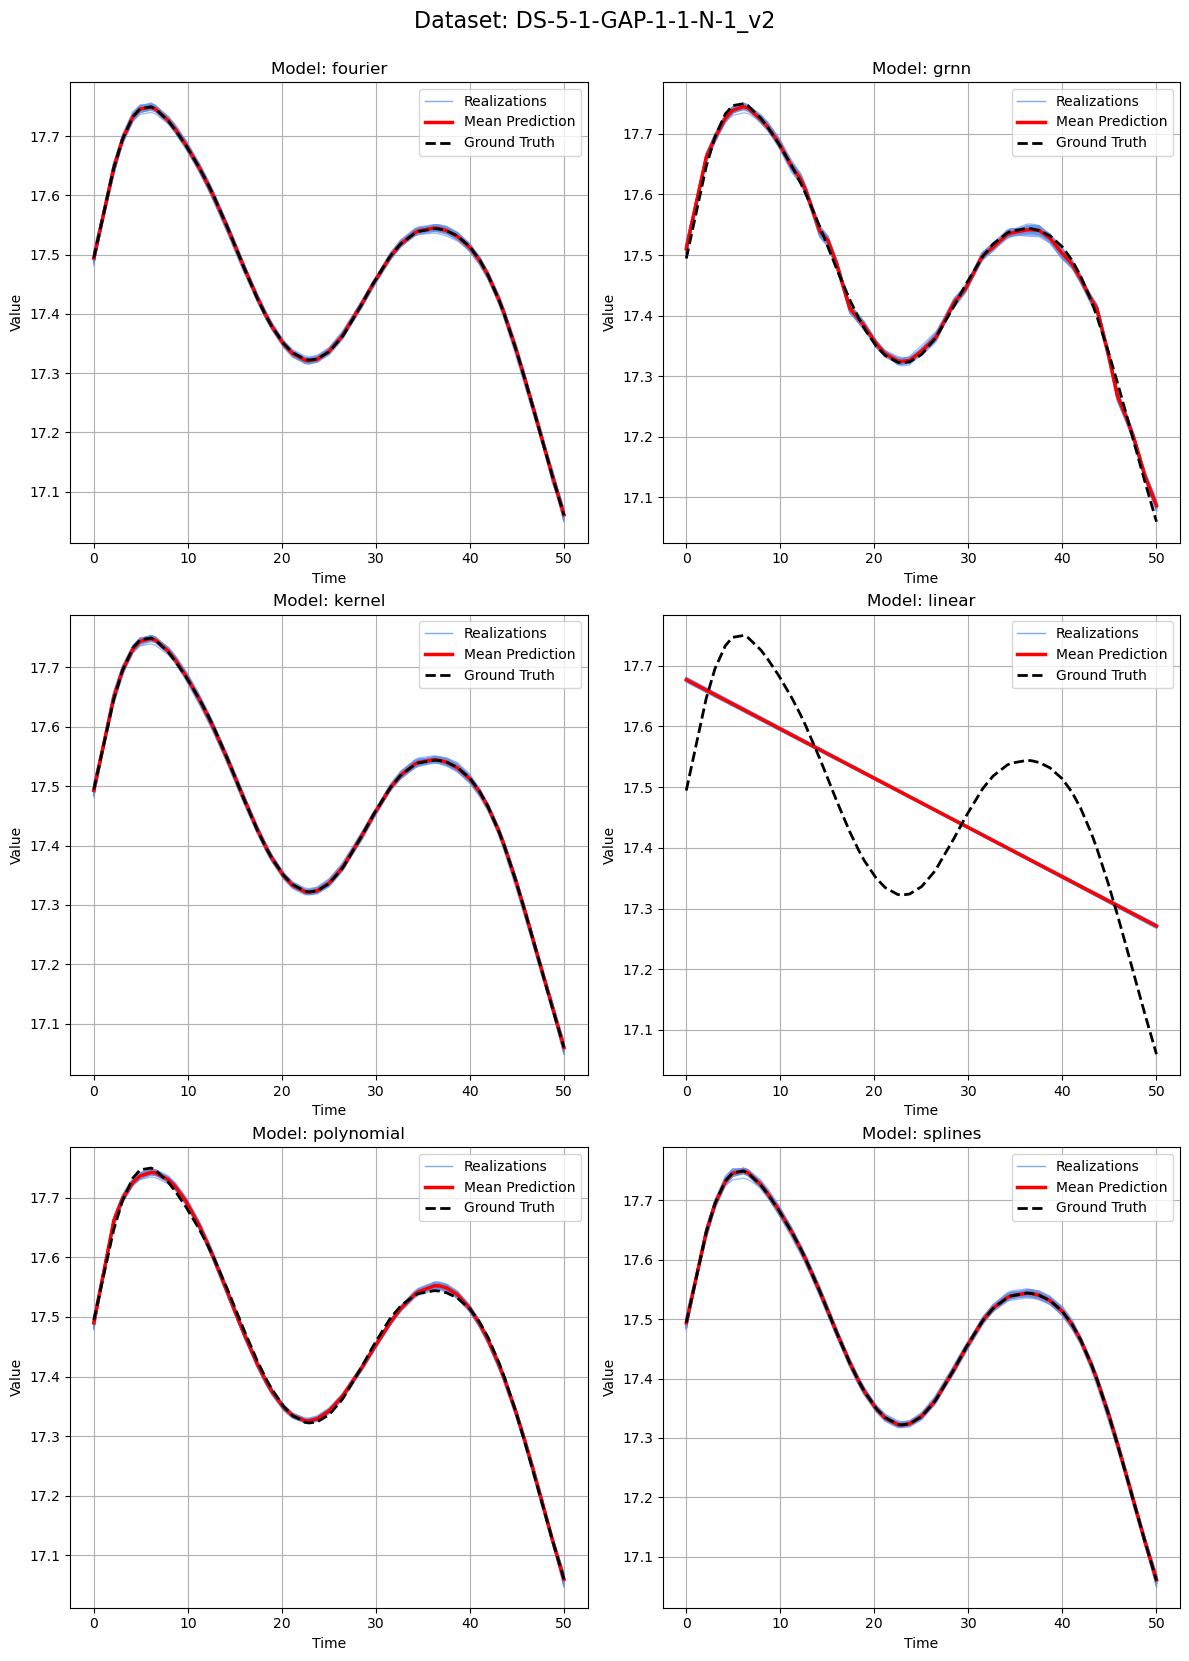

In [80]:
plot_predictions_for_each_model(x_truth, y_truth, predic[0], "DS-5-1-GAP-1-1-N-1_v2")

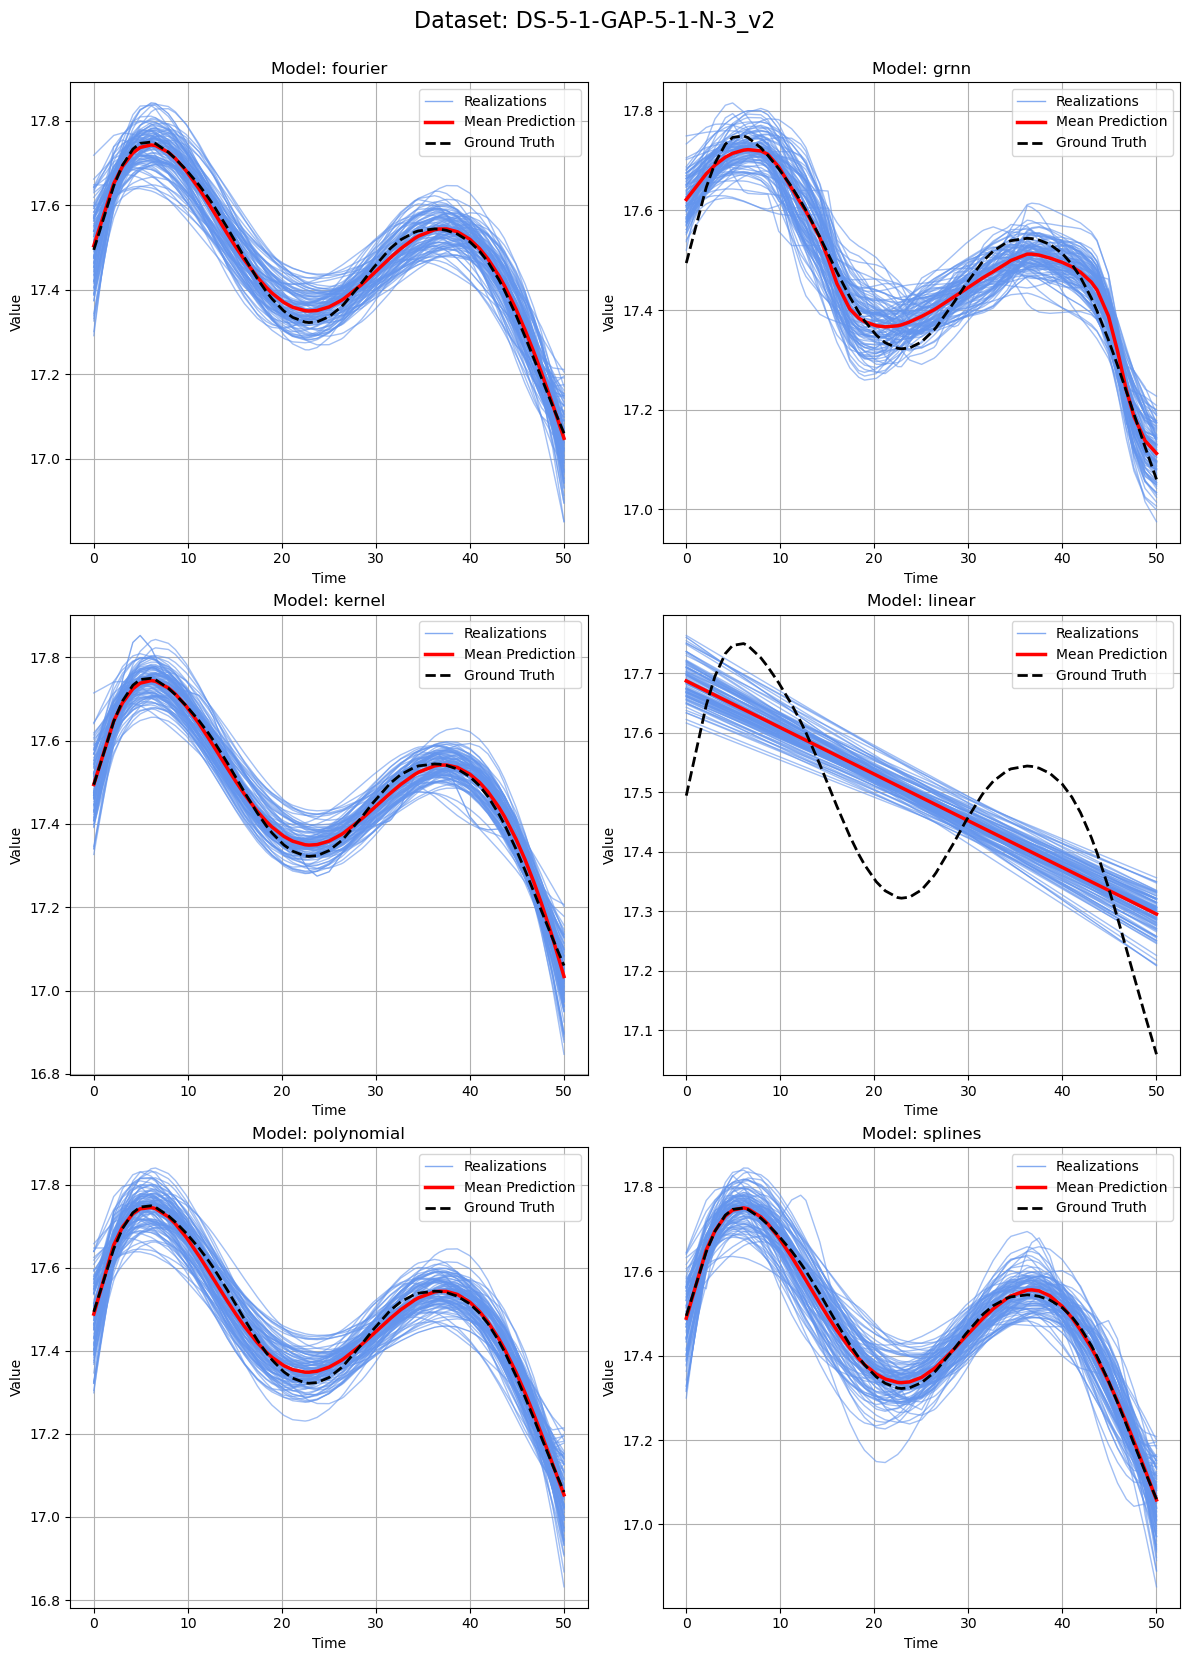

In [81]:
plot_predictions_for_each_model(x_truth, y_truth, predic[1], "DS-5-1-GAP-5-1-N-3_v2")

## Bias-Variance Tradeoff

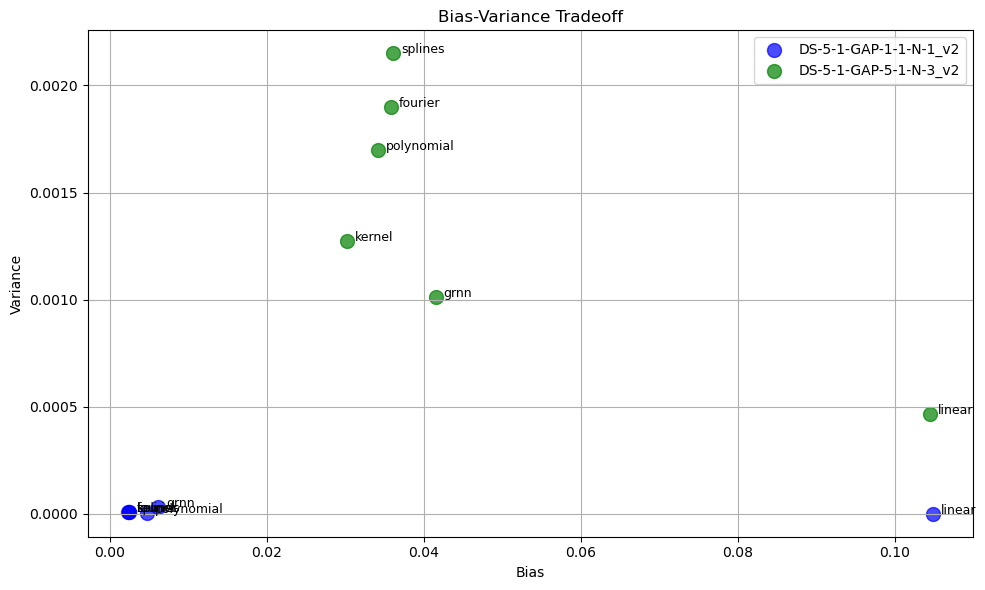

In [64]:
bias_values = [df_results[0]["Bias"].tolist(), df_results[1]["Bias"].tolist()]
variance_values = [df_results[0]["Variance"].tolist(), df_results[1]["Variance"].tolist()]

plot_comparison_bias_vs_variance(bias_values, variance_values, model_names)

## Conclusions

In [65]:
# First dataset with lower noisy
best_model_row = df_results[0].loc[df_results[0]['Bias'].idxmin()]
print("\nBest model on DS-5-1-GAP-1-1-N-1:")
print(best_model_row)


Best model on DS-5-1-GAP-1-1-N-1:
Name         Splines deg=3
MSE_train          0.00002
MSE_test          0.000009
Bias              0.002375
Variance          0.000009
Name: 5, dtype: object


In [66]:
# First dataset with lower noisy
best_model_row = df_results[1].loc[df_results[1]['Bias'].idxmin()]
print("\nBest model on DS-5-1-GAP-1-1-N-1:")
print(best_model_row)


Best model on DS-5-1-GAP-1-1-N-1:
Name         Kernel Ridge
MSE_train        0.005728
MSE_test         0.001502
Bias             0.030197
Variance         0.001273
Name: 2, dtype: object
